In [111]:
import pandas as pd
import code_base as cb
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm


# **Group Project - Earnings Adjusted Momentum & Value**

**Group-21** <br>
Member: LAM Chun Ming <br>
EID: 58555905 <br>


## **1 Introduction** 
The phenomenon of abnormal returns surrounding corporate earnings releases has been documented since the late 1960s. Beaver (1963) first showed that annual earnings announcements convey significant information in a single event, producing significant abnormal returns in a narrow window around release dates. Ball and Brown (1968) measured significant returns around the earnings announcement day in a [+1,-1] window. Brown and Warner (1985) then reconfirmed these results by showing the persistence even accounting for other factors, whilst many other works propose explanations to this phenomenon, from information asymmetry (Chari et al, 1988), attention-grabbing effects (Lee, 1992), as well as its persistence in global markets.

However, given that much of the academic literature has demonstrated and focused on the strong effect in a tight window around 1-2 weeks, before and after the earnings accrual day, longer-term effects have been less focused on. Some studies have looked into earning announcement drift that show the effect lasts on a longer horizon up to 60 trading days (Bernard & Thomass, 1989). However, they are less integrated with the complete momentum value framework.

The current factor framework was attributed to Fama and French  (1992) and subsequent work, and more recently, Asness (2013) shows that the combination of value and momentum factors outperformed each alone. Whilst some studies have examined the relationship between earnings and momentum (Chan, Jegadeesh and Lakonishok 1996), we wish to investigate the interplay of earnings signals of momentum value strategies. Given we might expect a significant earnings shock to materially alter a stock's momentum and value characteristics in the coming months, especially given large surprises. 







## **2 Data** 

### **2.1 Collection Method**
We collected 21 years of monthly data from 2000 to 2021 from a Bloomberg Terminal, which was used to generate a 20-year backtest period between 2001 and 2001. The first year was unusable as the momentum factor requires a 12-month lookback period. 

Specifically, we collected the adjusted closing price, market cap, announcement earnings, announcement earnings estimate, price to book ratio, and S\&P 500 membership information data, totalling 264 sample periods and 1134 stock tickers, which were all stock tickers that were members of the S\&P 500 at any point within this period.

Membership information is sampled at the end of the year, whilst stock data is sampled at the start of the month. Lastly, any announcement information is sampled at the time of announcement, then attributed to the month at which it occurred (for example, announcement in 2003-05-23 -> 2003-05)

### **2.2 Data Formatting**
Using the data collected, we then created Momentum (MOM), Value (VAL), and Earnings Surprise (SUP) fields.

In [112]:
# importing the collected data
df_dict = cb.read_multi_csv(
    filenames=["df_memboolG_spx","df_mcap_spx","df_monthly_spx","df_annsup_spx","df_annest_spx","df_anndat_spx","df_annacc_spx","df_P2BR_spx","df_Beta_spx"],
    name = ["tmbool", "mcap", "price", "annsup", "annest", "anndat", "annacc", "ptbr", "beta"]
)
df_dict["tmbool"].shape

(264, 1134)

#### **Factor Constructution: Value (VAL)**
The value factor "**VAL**" is the inverse of the price to book ratio (PTBR), to which we applied mean, standard deviation normalisation from the cross-sectional mean and standard deviations at time $t$

$$ \text{V}_{t,i} = \frac{1}{\text{PTBR}_{t,i}}$$
$$ \text{VAL}_{t,i} = \frac{V_{t,i} - \mu_t }{\sigma_t}$$

In [113]:
# value factor, normalisation applied later
df_dict["VAL"] = 1/df_dict["ptbr"]

#### **Factor Construction: Momentum (MOM)**
We created this first from calculating the monthly returns, due to our notation, this is the returns for holding stock ticker $[i]$ from period $[t-1] \to [t]$ 

$$ R_{t,i} = \frac{P_{t,i} - P_{t-1,i}}{P_{t-1,i}}$$

The momentum factor "**MOM**" is then the cumulative returns of the past year, excluding the most recent month. We then applied a mean standard deviation normalisation (again applied later)

$$M_{t,i} = \prod_{k=1}^{12}{(1+R_{t-k,i})}$$
$$ \text{MOM}_{t,i} = \frac{M_{t,i} - \mu_t }{\sigma_t}$$

In [114]:
# creating stock returns 
df_dict["ret"] = (df_dict["price"]/df_dict["price"].shift(1))-1

# calculating momentum factor, the returns from -2 to -12
tdf = pd.DataFrame(df_dict["ret"])
tdf +=1 
tdf = tdf.rolling(11,11).apply(np.prod, raw=True)
tdf = tdf**(1/11)

df_dict["MOM"] = tdf.shift(1)
df_dict["MOM"] -=1



#### **Factor Construction: Earnings Surprise & Other Earnings Data (SUP, ERG, ETG)**
We delayed (shifted) actual Earnings results by 1 period to prevent any hindsight bias (for example, earnings announced: 2003-05-23 => data collected: 2003-05, => data available: 2003-06). We did not delay the earnings estimate as we assume reasonable estimates are likely available by the start of the month

The surprise factor is directly collected from Bloomberg and delayed by 1 period; mathematically, this is simply the difference between actual earnings and earnings estimate. For factor "**SUP-Z**" we then applied the mean standard deviation normalisation, whilst for factor "**SUP**" we did not. 

We then also created supplementary factors like earnings growth "**ERG**" and earnings estimate growth "**ETG**", which are the % growth from four earnings announcements ago. We chose four earnings announcements as earnings are typically quarterly, and can also be seasonal; this choice allows us to focus on relative growth on an annual basis, to which we applied a standard deviation normalisation

$$E_{t,i} = \frac{E_{t,i}-E_{i}^{[4]}}{E_{i}^{[4]}}$$

$$\text{ERG}_i \text{/}\text{ETG}_i = \frac{E_{t,i}}{\sigma_t} $$





In [115]:

# shifting regieme by 1 to prevent hindsight bias  
df_dict["annacc"]=df_dict["annacc"].shift(1)
df_dict["annsup"]=df_dict["annsup"].shift(1)

# creating a earnings suprise factor (SUP/ SUP-Z)
df_dict["SUP"] =  df_dict["anndat"].shift(1)*df_dict["annsup"]
# df_dict["SUP"].ffill(inplace=True)
df_dict["SUP-Z"] = df_dict["SUP"].copy()
df_dict["SUP-Z"].ffill(inplace=True)

# earnings growth factor (ERG)
df_dict["AP4"] = cb.past_nvalid_values(df_dict["annacc"],4)
ans = (df_dict["annacc"].divide(df_dict["AP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ERG"] = ans
df_dict["ERG"].ffill(inplace=True)

# earning estimates (EST), actual earnings (ERN)
df_dict["EST"] = df_dict["annest"]

df_dict["EP4"] = cb.past_nvalid_values(df_dict["annest"],4)
ans = (df_dict["annest"].ffill().divide(df_dict["EP4"])-1)
ans[ans<-100]=-100
ans[ans>2000]=2000
df_dict["ETG"] = ans
df_dict["ETG"].ffill(inplace=True)

In [116]:


# size factor
df_dict["CAP"] = df_dict["mcap"]

out_dict = cb.dict_transfer(df_dict,["ret","VAL","MOM","SUP","ERG","CAP","ETG","SUP-Z"])

#### **In Sample & Out of Sample Sets**
We split the collected data into an In Sample (60% from 2001 -> 2013) and Reserved Out of Sample Data Set (40% from 2013-> 2021) to reduce bias and data mining risks

In [117]:
# generate a "test" set & "training" set
tmbool =  df_dict["tmbool"].copy()
# ratio = 60%
ratio = 0.6
row = int(round((tmbool.shape[0])*ratio,0))
tmbool_train = tmbool.iloc[12:row,:]
tmbool_test = tmbool.iloc[row:,:]

#### **Normalisation**

we then applied mean standard deviation normalisation to Momentum Factor and Value Factor to cacluat standard scores.

we also applied just standard deviation normalistion to our supplimentary factors (ERG and ETG) to preserve the positive and negative directional information

values above 5 ("standard deviations") are  discarded by setting them to 0, as they likely represent extereme cases data points less suitable to high level statistical analysis



In [118]:

data = cb.data_obj(tmbool,out_dict)

# apply nomalisation
data.calc_z_scores(True,["MOM","VAL"],clip="Discard")
data.calc_z_scores(True,["ERG","ETG","SUP-Z"],False,clip="Discard")



## **3 Emperical Analysis**
### **3.1 Portfolio Construction and Momentum and Value Benchmark**
We first investigate the effect of the value and momentum factor portfolio, which is used as our benchmark.

Following Asness 2013, we construct a composite score by taking the simple average of our momentum and value standard score. 

$$S_{i,t} = 0.5 * \text{MOM}_{i,t} + 0.5*\text{VAL}_{i,t}$$

We construct the portfolio by ranking all scores and holding a long position in the top 30% of all stocks, whilst shorting the bottom 30%, for each stock selected, they hold equal weighting and both long and short portfolio net to 0 for a dollar neutrality overall

As our returns are constructed as the returns holding stock $[i]$ from period $[t-1]->[t]$, we shift our portfolio weights one period forward to represent returns from $[t]->[t+1]$. Each month, the portfolio is rebalanced in accordance with our score. We apply a 10 basis point net  transaction fee representing any transaction costs and slippage , calculated as the difference between the portfolio weights in each period.




In [119]:
# calculate momentum value composite factor  
momval = (0.5*data.get("VAL").fillna(0)
          +0.5*data.get("MOM").fillna(0))
data.append("MOM_VAL", momval)
# data.regulate(["MOM_VAL"])
# data.calc_z_scores(inplace=True,fields=["MOM_VAL"])
port_momval = data.to_port("MOM_VAL",tmbool=tmbool_train)


port_momval.gen_weights_from_score(0.3)
momval_ret, momval_cret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)




To evaluate the result of our momentum & value portfolio, we also applied the same method to our momentum and value factors by themselves, we then plotted the cumulative long-short portfolio factor returns, net of transaction fees below

Text(0.5, 1.0, 'Factor Portfolio Comparison')

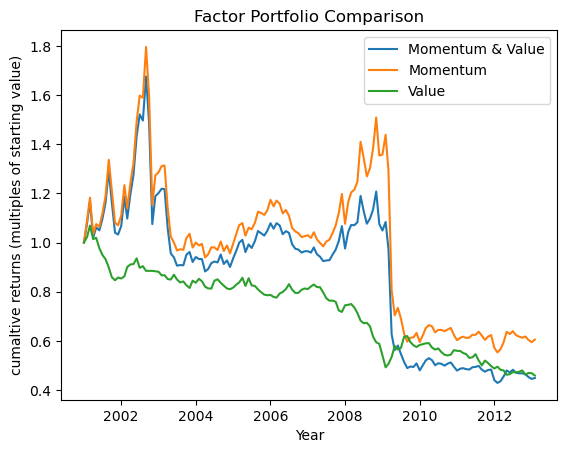

In [120]:
port_mom = data.to_port("MOM",tmbool=tmbool_train)
port_mom.gen_weights_from_score(0.3)
mom_ret, mom_cret = port_mom.get_port_ret(weight=port_mom.lsw,bps=10)

port_val = data.to_port("VAL",tmbool=tmbool_train)
port_val.gen_weights_from_score(0.3)
val_ret, val_cret = port_val.get_port_ret(weight=port_val.lsw,bps=10)

comb_ret = (val_ret+mom_ret)/2
comb_cret=(comb_ret+1).cumprod()
# ploting graph
plt.plot(momval_cret)
plt.plot(mom_cret)
plt.plot(val_cret)

plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")



In [121]:
# Information Ratios
print("Information Ratios")
print("Combined Relative to Momentum : {}".format(round(cb.infomation_ratio(momval_ret,mom_ret),3)))
print("Combined Relative to Value : {}".format(round(cb.infomation_ratio(momval_ret,val_ret),3)))

Information Ratios
Combined Relative to Momentum : -0.269
Combined Relative to Value : 0.022


We actually find that all factors portfolios underperformed the S&P 500 index, but also that the value and momentum combined portfolio also underperformed the momentum factor by itself. This is contrary to the findings in Asness 2013. Nevertheless, we shall use this as our benchmark, due to our stated research interest 

#### **Investigating the result: Different Long Short Portfolios**

Text(0.5, 1.0, 'Quantile Portfolio Comparison')

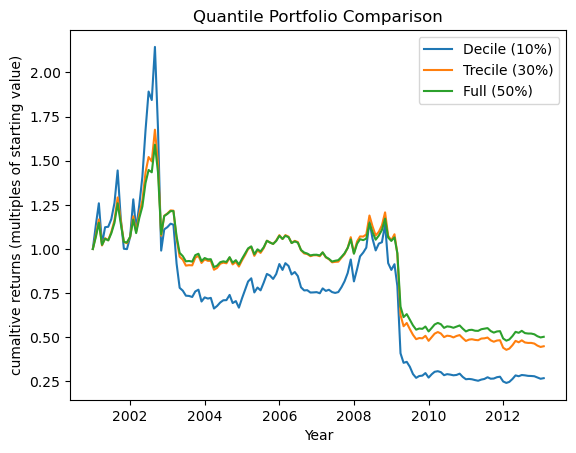

In [122]:
# Decile Portfolios (10%)
port_momval.gen_weights_from_score(0.1)
momval_tret, momval_tcret = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

# Trecile Portfolios (30%), standard in Fama French
port_momval.gen_weights_from_score(0.3)
momval_tret2, momval_tcret2 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

# Full Portfolios (50%), holding the entire universe
port_momval.gen_weights_from_score(0.5)
momval_tret3, momval_tcret3 = port_momval.get_port_ret(weight=port_momval.lsw,bps=10)

plt.plot(momval_tcret)
plt.plot(momval_tcret2)
plt.plot(momval_tcret3)

plt.legend(["Decile (10%)","Trecile (30%)","Full (50%)"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Quantile Portfolio Comparison")


In [123]:
# Information Ratios
print("Information Ratios Relative to Decile (10%) Portfolio")
print("Trecile (30%) Portfolio : {}".format(round(cb.infomation_ratio(momval_tret2,momval_tret),3)))
print("Full (50%) Portfolio : {}".format(round(cb.infomation_ratio(momval_tret3,momval_tret),3)))


Information Ratios Relative to Decile (10%) Portfolio
Trecile (30%) Portfolio : 0.024
Full (50%) Portfolio : 0.027


We see that the trecile portfolio actually captures the majority of the benefits. A full portfolio only offers marginal improvements, whilst the decile portfolios actually risk overconcentration and noise. 

We conclude here that the bad performance was **not** due to our choice of this value.

#### **Investigating the result: Long vs Short Portfolios**
Next, we investigate further the impact of the long and short portfolios. Again, we did not see an outperformance from our momentum and value factors; however, we do see that the factor performance is much stronger on the long side

Text(0.5, 1.0, 'Factor Long Portfolio Comparison')

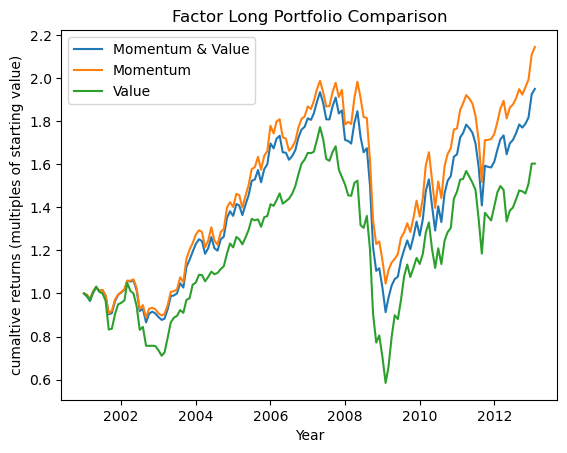

In [124]:

momval_tret, momval_tcret = port_momval.get_port_ret(weight=port_momval.lw,bps=10)
mom_tret, mom_tcret = port_mom.get_port_ret(weight=port_mom.lw,bps=10)
val_tret, val_tcret = port_val.get_port_ret(weight=port_val.lw,bps=10)


plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)


plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Long Portfolio Comparison")



Text(0.5, 1.0, 'Factor Short Portfolio Comparison')

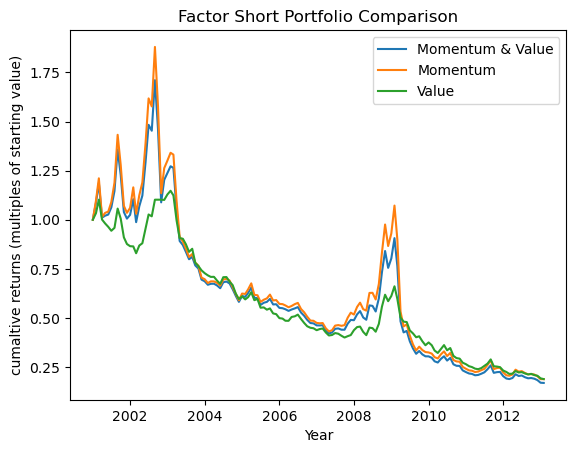

In [125]:
_, momval_tcret = port_momval.get_port_ret(weight=port_momval.sw,bps=10)
_, mom_tcret = port_mom.get_port_ret(weight=port_mom.sw,bps=10)
_, val_tcret = port_val.get_port_ret(weight=port_val.sw,bps=10)

plt.plot(momval_tcret)
plt.plot(mom_tcret)
plt.plot(val_tcret)

plt.legend(["Momentum & Value","Momentum","Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Short Portfolio Comparison")


Again, there has been no outperformance from the value momentum portfolio. Furthermore, we can also observe that the short portfolios for all factors have been suffering from losses equal to or greater than their long portfolios; and in times of large drawdowns, the gains from the short portfolios were insufficient to cover for losses from the long portfolios. 

**this suggests perhaps uniquely from this data set:**

- **From the momentum effects:** this suggests that most stocks in the market have been going up at similar rates regardless of past returns (pointing to a high level of market efficiency during normal periods), whilst in drawdown events, the fastest growing stocks are also drawing down much quicker than low-returning stocks 

- **From the value effects:** cheap stocks have consistently underperformed in this universe (this might be the case, as it is a managed large cap index where relatively cheap stocks in the index are not truly "cheap")

- **Most Interestingly:** As can be seen from the figure below, it is the most expensive (**Inverse Momentum**) stocks that have outperformed, both the recently highest returning stocks, as well as the cheapest stocks. 

Text(0.5, 1.0, 'Factor Portfolio Comparison')

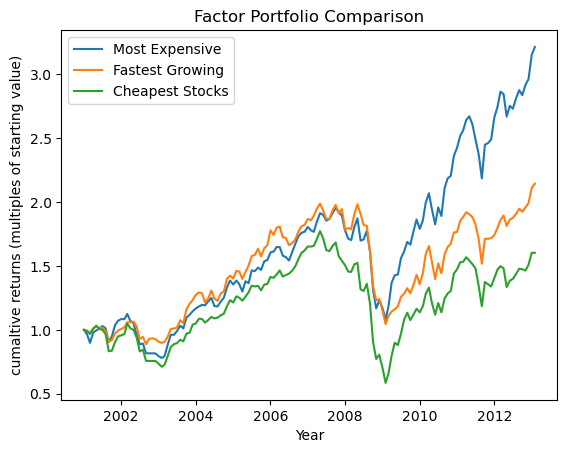

In [126]:
# ploting graph
_, val_tcret = port_val.get_port_ret(weight=-port_val.sw,bps=10)
_, mom_tcret = port_val.get_port_ret(weight=port_mom.lw,bps=10)
_, val2_tcret = port_val.get_port_ret(weight=port_val.lw,bps=10)

plt.plot(val_tcret)
plt.plot(mom_tcret)
plt.plot(val2_tcret)

plt.legend(["Most Expensive","Fastest Growing","Cheapest Stocks"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")

### **3.2 Method 1 : Earnings Factors, and Simple Combined Score**
To try to incorporate the idiosyncratic effects from earnings and investigate how they affect momentum and value on a monthly frequency, we first investigate a straightforward approach from our earnings growth, earnings estimate, and surprise factors

(Note in doing so, we are implicitly disagreeing with the market efficiency hypothesis, where excess returns are only given to the undertaking of risk)


To do so, we follow a 3-step plan
1) construct single-factor portfolios, **inspect for negatively correlated Factor Returns** (this comes from our understanding that the negative factor correlation can complement portfolio returns)
2) **consider if fundamental reasoning behind the negative correlation exists** (for example, Earnings Surprise can serve as additional inputs to whether a momentum trend continues, whilst Earnings Growth and Earnings Estimates Growth can not only do the former but provide information on a value stock's future price)
3) **construct a combined score portfolio** as before


#### **Constructing Simple Factor Portfolios**

Text(0.5, 1.0, 'Factor Portfolio Comparison')

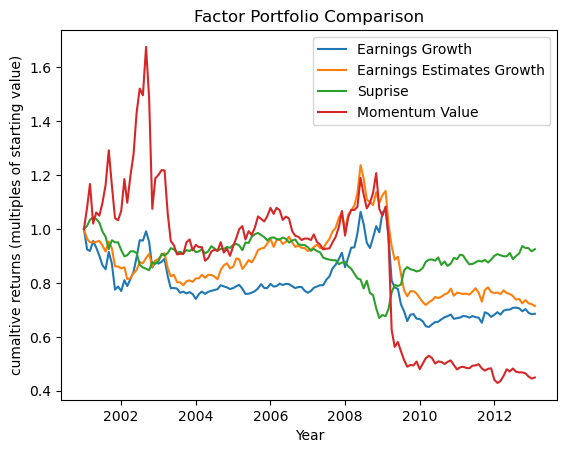

In [127]:
# Earnings Growth Portfolio
port_erg = data.to_port("ERG",tmbool=tmbool_train)
port_erg.gen_weights_from_score(0.3)
_, erg_cret = port_erg.get_port_ret(weight=port_erg.lsw,bps=10)
plt.plot(erg_cret)

# Earnings Estimates Portfolio
port_etg = data.to_port("ETG",tmbool=tmbool_train)
port_etg.gen_weights_from_score(0.3)
_, etg_cret = port_etg.get_port_ret(weight=port_etg.lsw,bps=10)
plt.plot(etg_cret)

# Earnings Suprise Portfolio
port_sup = data.to_port("SUP-Z",tmbool=tmbool_train)
port_sup.gen_weights_from_score(0.3)
_, sup_cret = port_sup.get_port_ret(weight=-port_sup.lsw,bps=10)
plt.plot(sup_cret)

plt.plot(momval_cret)

plt.legend(["Earnings Growth","Earnings Estimates Growth","Suprise", "Momentum Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")

#### **Factors Selection & Creation**

Here we see that Earnings estimates growth has much more "information" than Earnings Growth as visible by the out-performance. However Earnings Suprise Factor likely be prefered as it would benefit from having the negative correlation to momentum and value.

There is also some fundamental reason to believe earnings surprise would contain additional information, as it provides information for market expectations. Whilst there are also some reasons to believe that Earnings Estimates Growth (ETG) can provide additional information to momentum and value, they **somewhat weaker** as prices should already reflect investor beliefs; therefore, we expect it to be less likely to hold in the out-of-sample period.

Finally, to create the factor using **SUP**, we adjusted the weighting as we found that an equal weight did not lead to any meaningful impact, therefore leading to a final weighting ratio of 0.5, 0.5 & 3

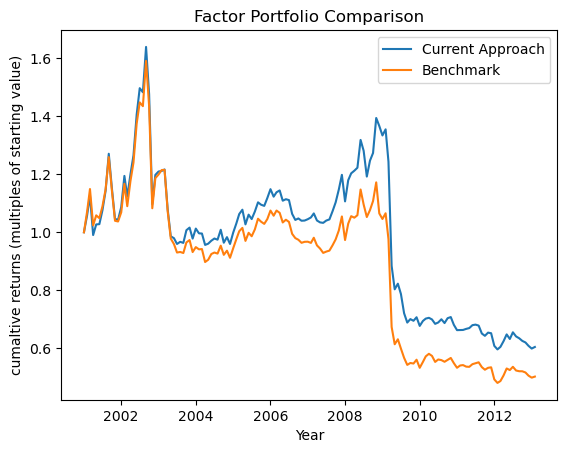

Approach information Ratio: 0.114
None


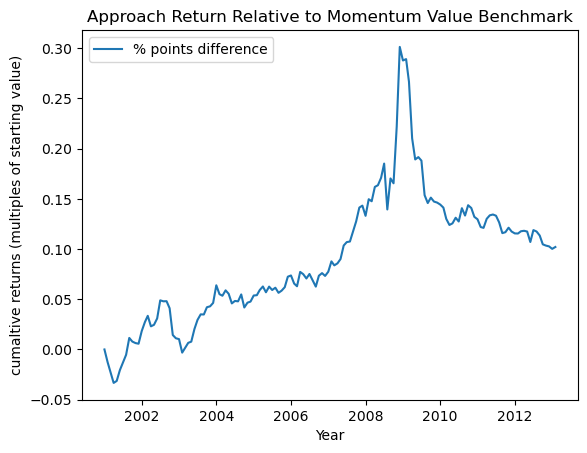

In [128]:
# calculate momentum value composite factor  
composite = (+0.5*data.get("VAL").fillna(0)
             +0.5*data.get("MOM").fillna(0)
             +3*data.get("SUP-Z").fillna(0))
data.append("COM", composite)

data.calc_z_scores(inplace=True,fields=["COM"])
port_com = data.to_port("COM",tmbool=tmbool_train)
port_com.gen_weights_from_score(0.3)

port_com.quick_plt_diff(port_momval)




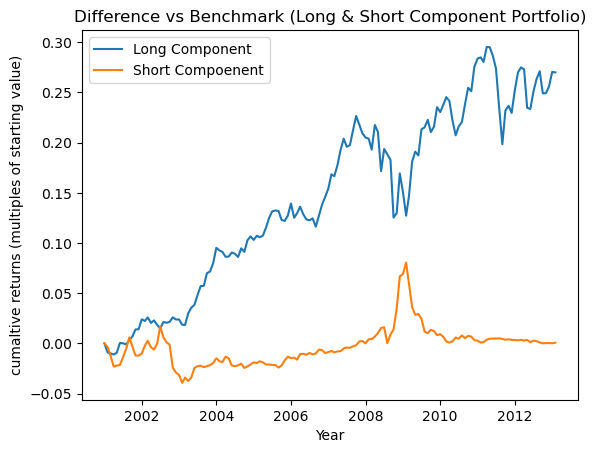

In [129]:
port_com.quick_plt_ls(port_momval)


This approach led to a positive, but small result. Empirically, we observed that this approach provides substantial alpha relative to our benchmark only up to 2008, and since then, the information provided from earnings surprise has been much less, if not negative. Earnings Surprise represents the new idiosyncratic information injected into the market; the reduction in the impact of this information suggests that the market has been more efficient since then. 


### **3.3 Method 2 : Conditional Factor Weighting**
We also attempted another approach. Here, we considered heuristically how the market would react to a large shock from earnings results for the month immediately following earnings. This led to the creation of 3 tables, each with 3 columns (High, Mid, Low Value), and 3 rows (High, Mid, Low Momentum) for each a positive shock, a negative shock, and a neutral shock scenario, which we translate into weights.

For our **base case** where the shock does not cross an earnings surprise percentage threshold of $50%$, we follow our original momentum value strategy. Due to the delayed nature of our earnings, and the literature indicating that most of the earnings announcement drift occurs around a small window, we to try to consider any secondary effect for the month immediately following. 

For the **positive shock case**, we tried to consider potential **mean reversal effects** where we model the effect of the large shock as not well understood, and large positive movements and negative movements are going to revert back to a more reasonable price.

**Positive Shock: Score Table**
|Momentum \ Value |High|Medium|Low|
|:-:|:-:|:-:|:-:|
|High| High | Medium | Very Low |
|Medium| High|  Medium |  Low |
|Low|Very High | High | Low| 

For the **negative shock case**, this is instead a **delayed effects** where an unexpected very large earnings surprise might uncover critical issues, which can be much more serious than a large positive shock.

**Positive Shock: Score Table**
|Momentum \ Value |High|Medium|Low|
|:-:|:-:|:-:|:-:|
|High| Medium | Medium |  Negative |
|Medium| Negative|  Negative |  Negative |
|Low|Very Negative | Very Negative | Very Negative | 

Translating this to weights, this leads to 

$$S_{i,t}^{[\text{Base}]} = +0.500* \text{MOM}_{i,t}+0.500* \text{VAl}_{i,t}+0.00$$
$$S_{i,t}^{[\text{Positive}]} = -0.175* \text{MOM}_{i,t}+0.875* \text{VAl}_{i,t}+0.00$$
$$S_{i,t}^{[\text{Negative}]} = +0.825* \text{MOM}_{i,t}-0.175* \text{VAl}_{i,t}-1.75$$

Here we point out that the bias values (intercept) do make an impact as each stock will be under separate earnings shock cases, therefore the overall ranking can be altered by how negative or positive the bias, and weight magnitude are, rather than just their relative ratios



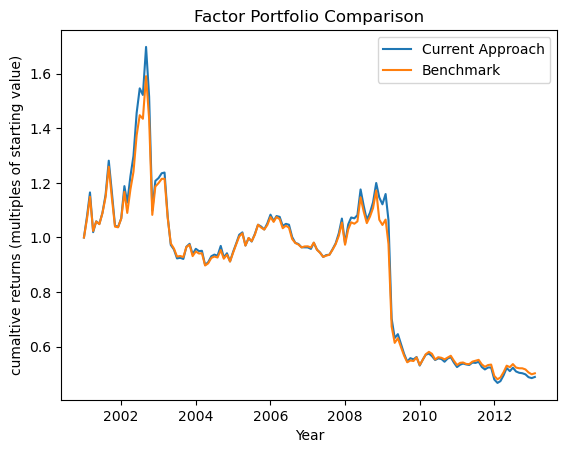

Approach information Ratio: 0.017
None


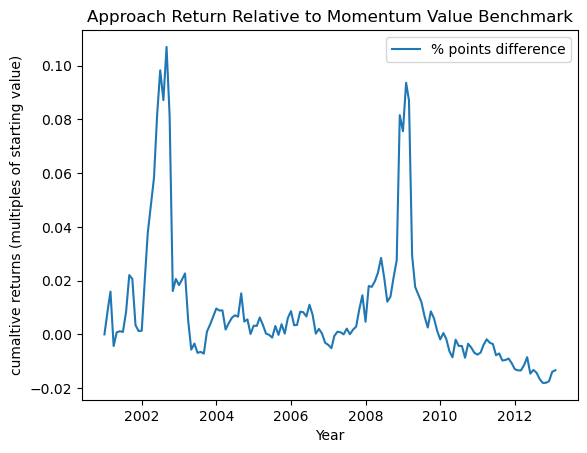

In [ ]:
try: 
    data.data_dict.pop("EJC")
except:
    pass 

sup = data.get("SUP")
mom = data.get("MOM")
val = data.get("VAL")

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)
cuttoff = 0.5

fmb = 0.5
fvb = 0.5
fcb = 0.0

fmp = -0.175
fvp = 0.875
fcp = 0.0

fmn = 0.825
fvn = -0.175
fcn = -1.75


# base case 
ejustc = fmb*mom + fvb*val + fcb

# positive case
ejustc[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# negative case
# cuttoff = 0.6

ejustc[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC",ejustc)


port_ejc = data.to_port("EJC", tmbool_train)
port_ejc.gen_weights_from_score(0.3)

port_ejc.quick_plt_diff(port_momval)



Here we see that this approach largely did not work from a long-term perspective. 

Individually from the long component, there is some additional information between early on, but by 2006, it has not provided alpha, and has since completely disappeared, if not negative. Again, supporting the theory that markets have become more efficient.

However, very interestingly, from its short component, it had provided a potential leading indicator to both momentum drawdown events where the short portfolio produced increasing positive relative returns (captured information) prior to drawdowns, which can be very useful in a market timing context to avoid momentum drawdowns.

This could make some fundamental sense as the short component (largely from the negative shock case) effectively captures the degree investors are willing to overlook large negative surprises, a measure of market uneasiness

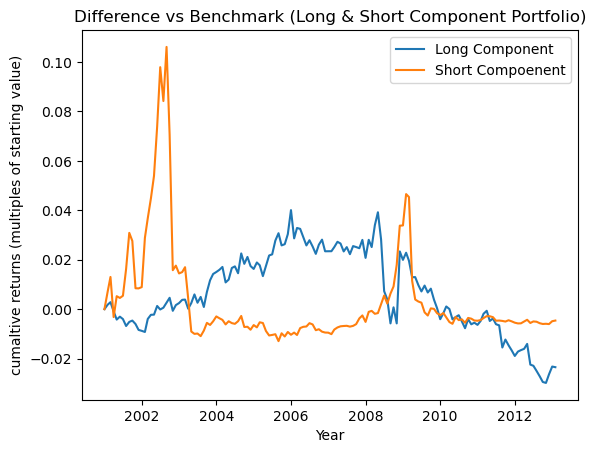

In [131]:
port_ejc.quick_plt_ls(port_momval)



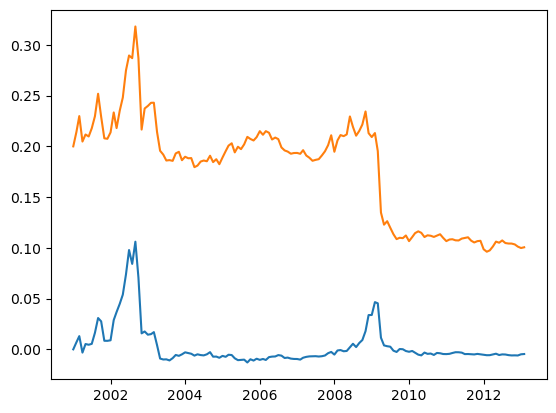

In [132]:
_, ejc_tcret= port_ejc.get_port_ret( port_ejc.sw, bps=10)
_, momval_tcret= port_momval.get_port_ret( port_momval.sw, bps=10)

_, momval_tcret2= port_momval.get_port_ret( port_momval.lsw, bps=10)

plt.plot((ejc_tcret-momval_tcret))
plt.plot((momval_tcret2)/5)

# plt.plot((ejc_tcret-momval_tcret).loc["2008-01-01":"2010-01-01"])
# plt.plot((momval_tcret2).loc["2008-01-01":"2010-01-01"]/20)

### **3.4 Method 3 Linear Regression Enabled Method**

Lastly, we also try to investigate whether linear regression techniques can improve factor performance by selecting better factor weights.


Here we applied simple least squares regression based on the conditional weights approach in method 3. First, we compile the factor scores into 3 data sets again by earnings surprise percentage threshold. The compiled data set is then used to predict next period returns.

In [133]:
sup = data.get("SUP").copy()
ret = data.get("ret").copy().shift(-1)
data.append("RET-ML",ret)

segment = tmbool_train

key = pd.DataFrame(False,index=segment.index,columns=segment.columns)

cuttoff=0.6

key_pos = key.copy()
key_pos[sup>=cuttoff]=True
mldf_pos = data.gen_mldf(["MOM","VAL","RET-ML"],key_pos)

key_neg = key.copy()
key_neg[sup<=-cuttoff]=True
mldf_neg = data.gen_mldf(["MOM","VAL","RET-ML"],key_neg)

key_base = key.copy()
key_base[(sup<cuttoff)&(sup>-cuttoff)]=True
mldf_base = data.gen_mldf(["MOM","VAL","RET-ML"],key_base)


model_pos, res_pos = cb.run_ml(mldf_pos)
model_neg, res_neg = cb.run_ml(mldf_neg)
model_base, res_base = cb.run_ml(mldf_base)



#### **Shock Cases**
Here we isolate the positive and negative shock cases, by fixing the base case to the simple momentum stratergy to see the effectiveness of the linear regression approach on the earnings shock cases alone 

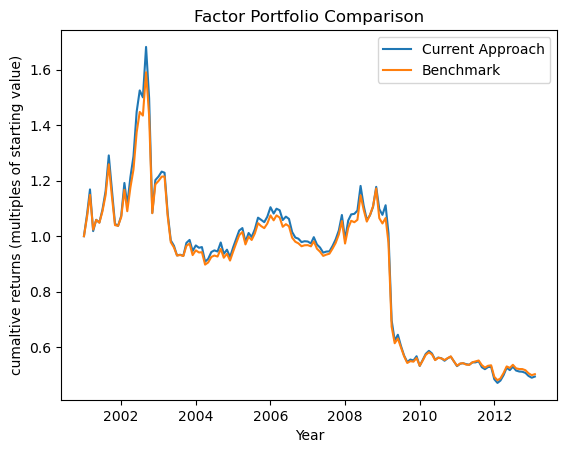

Approach information Ratio: 0.022
None


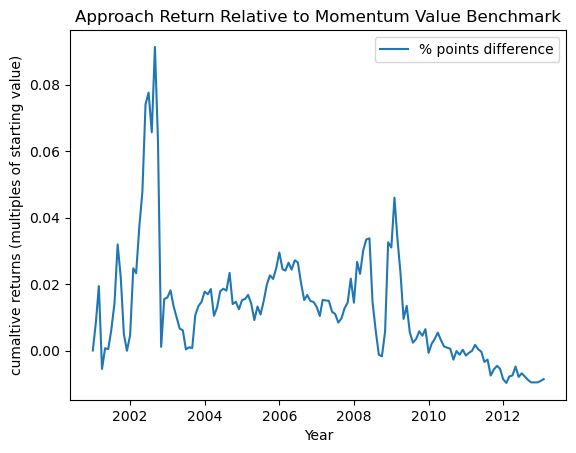

In [ ]:
try: 
    data.data_dict.pop("EJC4")
except:
    pass 

sup = data.get("SUP").copy()
mom = data.get("MOM").copy()
val = data.get("VAL").copy()

mom.fillna(0,inplace = True)
val.fillna(0,inplace = True)

fmb = 0.5 
fvb = 0.5 
fcb = 0.0 

fmp = res_pos.params[0]
fvp = res_pos.params[1]
fcp = res_pos.params[2]

fmn = res_neg.params[0]
fvn = res_neg.params[1]
fcn = res_neg.params[2]

# basecase 
ejustc4 = fmb*mom + fvb*val + fcb

# positive
ejustc4[sup>=cuttoff] = fmp*mom[sup>=cuttoff] + fvp*val[sup>=cuttoff] + fcp

# neg
ejustc4[sup<= -cuttoff] = fmn*mom[sup<= -cuttoff] + fvn*val[sup<= -cuttoff] + fcn

data.append("EJC4",ejustc4)
port_ejc4 = data.to_port("EJC4", tmbool_train)
port_ejc4.gen_weights_from_score(0.3)
port_ejc4.quick_plt_diff(port_momval)



#### **Shock Case Evaluation**
Here, whilst we saw a positive information ratio, it is very small, whilst neither the aggregate nor the long short components displayed any noticeable trends or patterns, rendering this approach **largely ineffective**

This is likely due to the highly non-linear nature of the return relationship with scores and a limited number of data points, making a simple linear regression inappropriate without strong fundamental priors

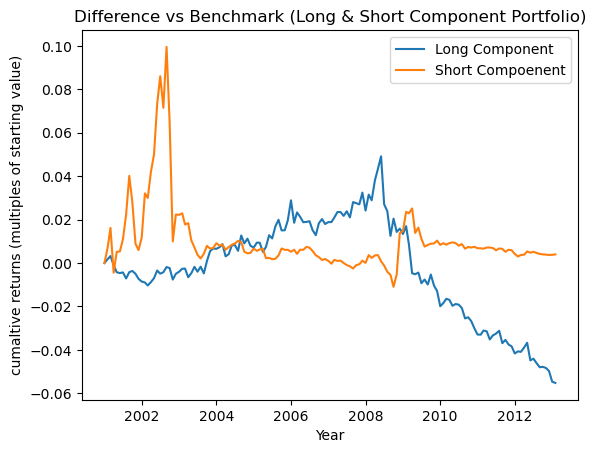

In [135]:
port_ejc4.quick_plt_ls(port_momval)

### **3.5 Out of Sample Evaluation**

So far, we have investigated three different approaches. Now we will consider their out-of-sample performance, before drawing final conclusions

#### **Benchmark** 
For our Momentum Value Portfolio, we once again see that it significantly underperformed the market-cap weighted index, as well as the momentum factor. This can be largely attributable to the very negative characteristics of the value factor as observed and discussed before   

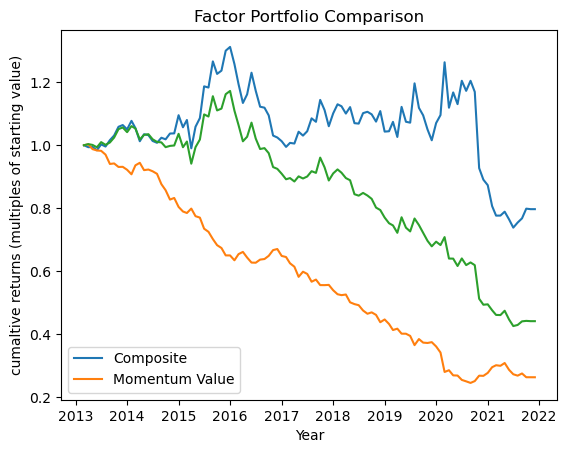

In [136]:
test_port_mom = data.to_port("MOM",tmbool=tmbool_test)
test_port_mom.gen_weights_from_score(0.3)
mom_test_rest, mom_test_crest = test_port_mom.get_port_ret(weight=test_port_mom.lsw,bps=10)

test_port_val = data.to_port("VAL",tmbool=tmbool_test)
test_port_val.gen_weights_from_score(0.3)
val_test_rest, val_test_crest = test_port_val.get_port_ret(weight=test_port_val.lsw,bps=10)

test_port_momval = data.to_port("MOM_VAL",tmbool=tmbool_test)
test_port_momval.gen_weights_from_score(0.3)
momval_test_rest, momval_test_crest = test_port_momval.get_port_ret(weight=test_port_momval.lsw,bps=10)

plt.plot(mom_test_crest)
plt.plot(val_test_crest)
plt.plot(momval_test_crest)


plt.legend(["Composite","Momentum Value"])
plt.xlabel("Year")
plt.ylabel("cumaltive returns (multiples of starting value)")
plt.title("Factor Portfolio Comparison")


factor_ret = pd.DataFrame(index = tmbool.index, columns = ["MOM","VAL"])
factor_ret.loc[tmbool_train.index,"MOM"] = mom_ret
factor_ret.loc[tmbool_train.index,"VAL"] = val_ret
factor_ret.loc[tmbool_test.index,"MOM"] = mom_test_rest
factor_ret.loc[tmbool_test.index,"VAL"] = val_test_rest
factor_ret["Intercept"] = 1


#### **Inverse Momentum**

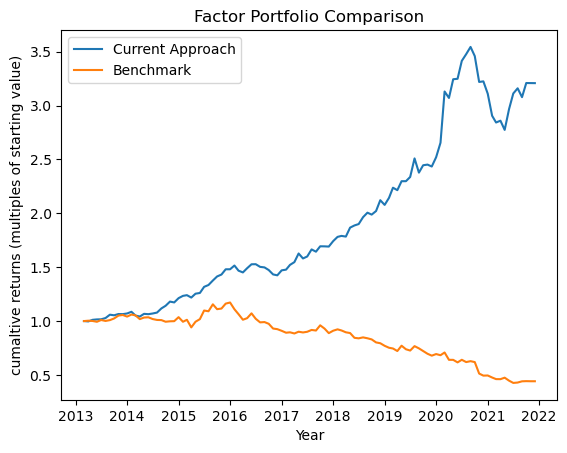

Approach information Ratio: 0.539
None


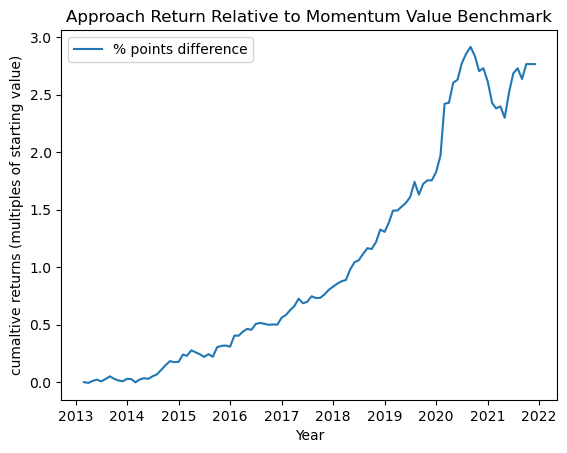

In [137]:
tdf = data.get("VAL")
data.append("INV",-tdf)

test_port_inv = data.to_port("INV",tmbool_test)
test_port_inv.gen_weights_from_score(0.3)
test_port_inv.quick_plt_diff(test_port_momval)

Here, once again, we see that the inverse momentum portfolio has been one of the most dominant factors for the S&P 5000

#### **Earnings Information: Composite Score**
Here, we see that the introduction of earnings surprise information improves the momentum value benchmark of the sample. The Information ratio has actually increased from the in-sample value of 0.114, and we do see a small increase in alpha from by ~0.6-1% annualised

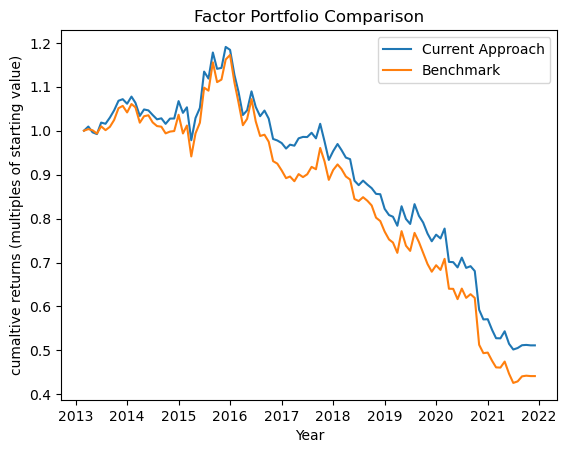

Approach information Ratio: 0.152
None


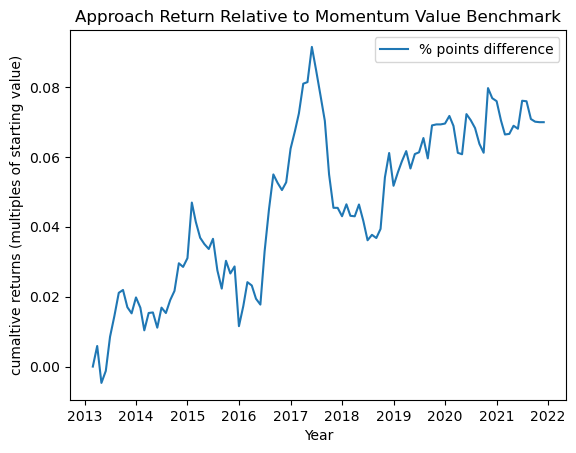

In [138]:
test_port_com = data.to_port("COM",tmbool=tmbool_test)
test_port_com.gen_weights_from_score(0.3)
test_port_com.quick_plt_diff(test_port_momval)




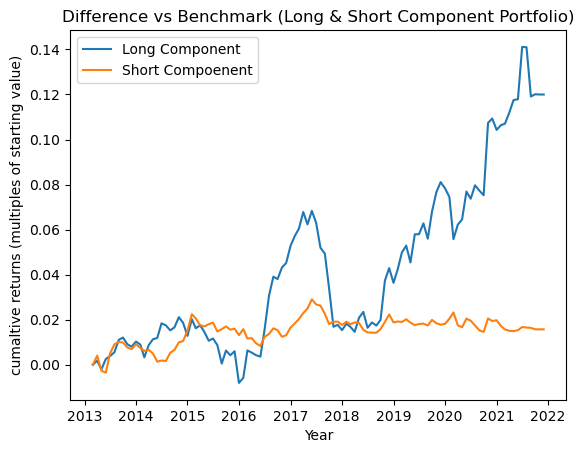

In [139]:
test_port_com.quick_plt_ls(test_port_momval)


We see that the returns generated largely from its long portfolio, which is consistent with in-sample observations. 

#### **Regression Analyis**
we ran a regression the following regression betwen, and observe whether if there is a change $\hat \alpha$ due to our stratergy
$$R_{t}^{[\text{MOM + VAL}]} = \alpha + \beta_{\text{MOM}} R_{t}^{\text{MOM}} + \beta_{\text{VAL}} R_{t}^{\text{VAL}} +\varepsilon_t$$
$$R_{t}^{[\text{Approach}]} = \hat\alpha + \hat\beta_{\text{MOM}} R_{t}^{\text{MOM}} + \hat\beta_{\text{VAL}} R_{t}^{\text{VAL}} +\varepsilon_t$$

we saw that here $\hat \alpha $ has increased from $-0.0009\%$ to $-0.0004\%$ monthly, furhtermore alpha has also became statistically insignifiant, suggesting that the earnings suprise factor do provide some information 

In [140]:
# alpha regression 
total_port_com = data.to_port("COM",tmbool=tmbool)
total_port_com.gen_weights_from_score(0.3)
rets,_ = total_port_com.get_port_ret(bps=10)

total_port_mom_val = data.to_port("MOM_VAL",tmbool=tmbool)
total_port_mom_val.gen_weights_from_score(0.3)
bench_rets,_ = total_port_mom_val.get_port_ret(bps=10)

X = factor_ret.copy()
X["Y"] = bench_rets
# factor_ret.
X.dropna(inplace=True)
Y = X.pop("Y")

X = X.astype(float)
ols_mod = sm.OLS(Y,X)
res = ols_mod.fit()
print(res.summary())

X = factor_ret.copy()
X["Y"] = rets
# factor_ret.
X.dropna(inplace=True)
Y = X.pop("Y")

X = X.astype(float)
ols_mod = sm.OLS(Y,X)
res2 = ols_mod.fit()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     6313.
Date:                Mon, 12 May 2025   Prob (F-statistic):          4.65e-214
Time:                        16:46:05   Log-Likelihood:                 888.65
No. Observations:                 252   AIC:                            -1771.
Df Residuals:                     249   BIC:                            -1761.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM            0.9473      0.009    108.979      0.0

In [141]:
# Factor Regression with Earnings Factor
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1976.
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.61e-153
Time:                        16:46:05   Log-Likelihood:                 780.19
No. Observations:                 252   AIC:                            -1554.
Df Residuals:                     249   BIC:                            -1544.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM            0.8097      0.013     60.573      0.0

#### **Earnings Information: Conditional Weights**
There have been little to no additional returns observed from this approach, largely similar to before. The use of its short component return as a potential indicator out of sample has been inconclusive, as the signal showcased different characteristics.  

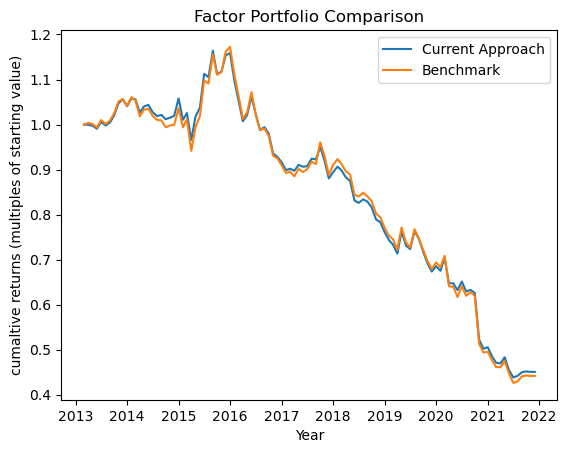

Approach information Ratio: 0.023
None


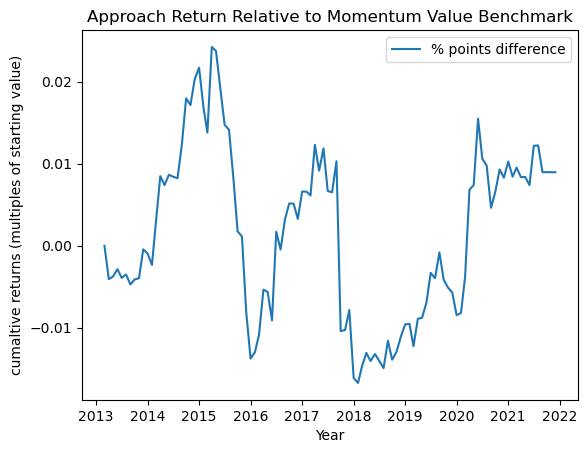

In [142]:
test_port_ejc = data.to_port("EJC",tmbool=tmbool_test)
test_port_ejc.gen_weights_from_score(0.3)
test_port_ejc.quick_plt_diff(test_port_momval)


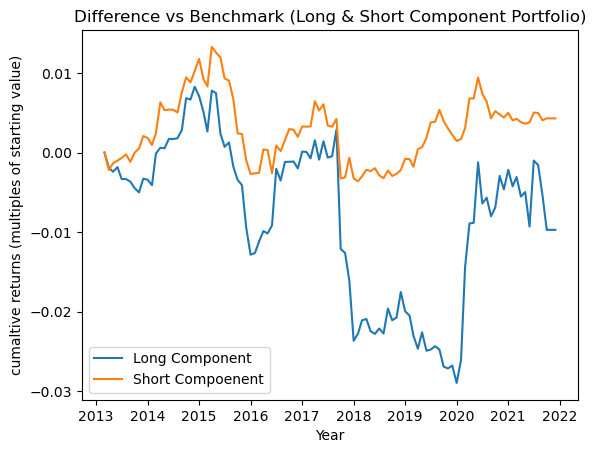

In [143]:

test_port_ejc.quick_plt_ls(test_port_momval)


Again, 's long component has failed to capture additional information. Instead, we are most interested in its short components, as a potential indicator for momentum drawdowns.


(Figure below) Whilst there is still an early indication from the signal, we saw the signal drawdown leading both the momentum returns and also the momentum drawdown significantly, potentially degrading its usefulness

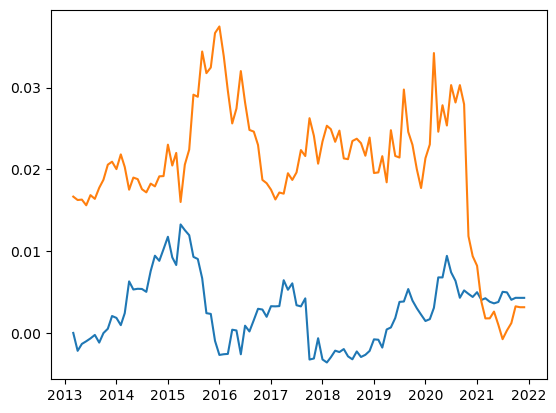

In [144]:
_, tcret = test_port_ejc.get_port_ret(test_port_ejc.sw,bps=10)
_, bench_tcret = test_port_momval.get_port_ret(test_port_momval.sw,bps=10)
_, mom_tcret= test_port_momval.get_port_ret( test_port_mom.lsw, bps=10)

plt.plot(tcret-bench_tcret)
plt.plot(mom_test_crest/15-0.05)

In [145]:
# alpha regression 
total_port_com = data.to_port("EJC",tmbool=tmbool)
total_port_com.gen_weights_from_score(0.3)
rets,_ = total_port_com.get_port_ret(bps=10)


X = factor_ret.copy()
X["Y"] = rets
# factor_ret.
X.dropna(inplace=True)
Y = X.pop("Y")

X = X.astype(float)
ols_mod = sm.OLS(Y,X)
res2 = ols_mod.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     4025.
Date:                Mon, 12 May 2025   Prob (F-statistic):          2.55e-190
Time:                        16:46:10   Log-Likelihood:                 845.82
No. Observations:                 252   AIC:                            -1686.
Df Residuals:                     249   BIC:                            -1675.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM            0.8962      0.010     86.986      0.0

did not produce much alpha improvement, instead it lowered the p value of alpha estimate 

#### **Earnings Information: Linear Regression Enabled**
Here, the observation and conclusion are the same as before, where the use of linear regression to select the switch case weights has been ineffective.

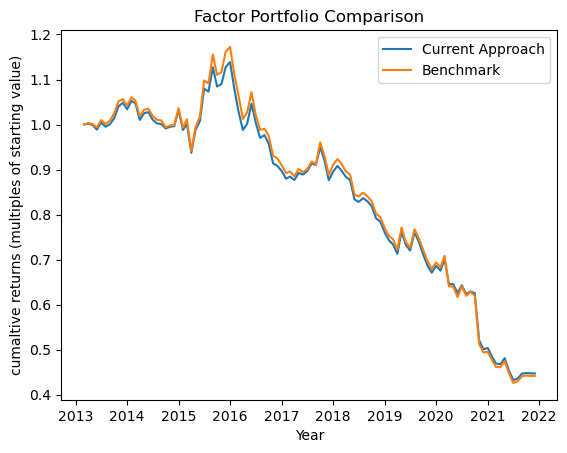

Approach information Ratio: 0.017
None


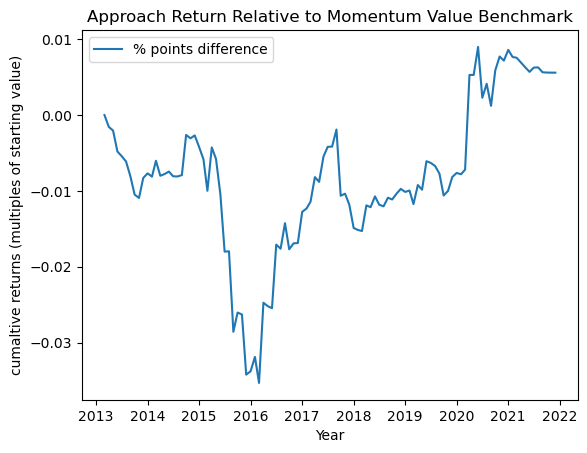

In [146]:
test_port_ejc3 = data.to_port("EJC4",tmbool=tmbool_test)
test_port_ejc3.gen_weights_from_score(0.3)
test_port_ejc3.quick_plt_diff(test_port_momval)


In [147]:
# alpha regression 
total_port_com = data.to_port("EJC4",tmbool=tmbool)
total_port_com.gen_weights_from_score(0.3)
rets,_ = total_port_com.get_port_ret(bps=10)


X = factor_ret.copy()
X["Y"] = rets
# factor_ret.
X.dropna(inplace=True)
Y = X.pop("Y")

X = X.astype(float)
ols_mod = sm.OLS(Y,X)
res2 = ols_mod.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     5285.
Date:                Mon, 12 May 2025   Prob (F-statistic):          1.17e-204
Time:                        16:46:14   Log-Likelihood:                 879.65
No. Observations:                 252   AIC:                            -1753.
Df Residuals:                     249   BIC:                            -1743.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
MOM            0.9000      0.009     99.900      0.0

some alpha is observed, however it is both small and hard to qualitatively interpret where it comes from, whithout much observable stratergy outperformance patterns making it impractical in reality 

## **4 Conclusions**
Throughout our experiments, we observed that the momentum value portfolio has **severely underperformed** both the underlying universe and the momentum portfolio in the backtest period between 2001 and 2021. This was due to a very dominant  "inverse value" effect, where the most expensive stocks consistently delivered high risk-adjusted returns. 

We then attempted to investigate whether a momentum value portfolio can improve by incorporating earnings information, using the following three approaches.

- **Composite Score**: calculate a composite score from the weighted sum of factor scores
- **Conditional Weights**: introducing conditional shock scenarios, and applying heuristic adjustments 
- **Linear Regression Enabled**: use of linear regression to estimate factor weights under different surprise scenarios

We found that the **composite Score method** has been the most effective both in and out of sample cases. Whilst the more complex latter two cases have been ineffective.

Although earnings information does provide some additional performance to momentum value stratergy, the overall effects have been small (information ratio of only ~0.1-0.2 and relative "alpha" of 0.6% annualised compared to our baseline),  with return profiles nearly identical to the underlying momentum value stratergy.

The inverse value dominated nature of the S&P 500, and the largely identical return profile, renders some metrics like max drawdowns meaningless; and any potential improvements to a momentum value stratergy impractical as the underlying stratergy returns have been very negative. Further work should explore whether our findings translate to other data sets where momentum value premiums are positive, and whether other earning factors can drive improvement.

### **Bibiography**